<h1 style="text-align: center"> Estimadores de Volatilidade </h1>

[Volatility Estimators - Hudson and Thames](https://www.mlfinlab.com/en/latest/feature_engineering/volatility_estimators.html)

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import math

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Set seaborn style for better aesthetics
# sns.set_theme(style='whitegrid')

from datetime import datetime

from utils.bs_funcs import *

%load_ext autoreload
%autoreload 2

In [2]:
## download stock data
ticker = 'BOVA11'
yf_ticker = [f'{ticker}.SA']
df =  get_stock_data(yf_ticker, period='5Y')

# ticker = '^bvsp'
# df =  get_stock_data(ticker, period='15Y')

window_size = 20

[*********************100%%**********************]  1 of 1 completed


## Close to Close Volatility

In [3]:
def cc_volatility(precos_fechamento: pd.DataFrame, periodos: int=20):
    cc_vol = precos_fechamento / precos_fechamento.shift(1)-1
    return cc_vol.rolling(periodos).std() * np.sqrt(252)

rolling_cc_volatility = cc_volatility(df['Adj Close'], window_size)
print(f'Adj Close-to-Adj Close Volatility: {rolling_cc_volatility.iloc[-1]:.2%}')

Adj Close-to-Adj Close Volatility: 13.68%


## Parkinson Volatility

In [4]:
def parkinson_volatility(df, periodos: int=20):
    hi_lo = (np.log(df['High'] / df['Low'])) ** 2
    pk_vol = np.sqrt(hi_lo.rolling(periodos).mean() / 4 * np.log(2)) * np.sqrt(252) 
    return pk_vol 

rolling_parkinson_volatility = parkinson_volatility(df, window_size)
print(f'Parkinson Vol: {rolling_parkinson_volatility.iloc[-1]:.2%}')

Parkinson Vol: 9.55%


## Garman-Klass Volatility

In [5]:
def garman_klass_volatility(df, periodos: int=20):
    hi_lo = (np.log(df['High'] / df['Low'])) ** 2
    cl_op = (np.log(df['Adj Close'] / df['Open'])) ** 2
    gk = 0.5 * hi_lo - (2 * np.log(2) - 1) * cl_op
    gk_vol = (np.sqrt(gk.rolling(periodos).mean())) * np.sqrt(252)
    return gk_vol

rolling_garman_klass_volatility = garman_klass_volatility(df, window_size)
print(f'Garman Klass Vol: {rolling_garman_klass_volatility.iloc[-1]:.2%}')

Garman Klass Vol: 14.52%


## Rogers-Satchell Volatility

In [6]:
def rogers_satchell_volatility(df, periodos=20):
    hi_cl = np.log(df['High'] / df['Adj Close'])
    hi_op = np.log(df['High'] / df['Open'])
    lo_cl = np.log(df['Low'] / df['Adj Close'])
    lo_op = np.log(df['Low'] / df['Open'])
    rs = np.sqrt((hi_cl * hi_op + lo_cl * lo_op).rolling(periodos).mean())
    rs_vol = rs * np.sqrt(252)
    return rs_vol 

rolling_rogers_satchell_volatility = rogers_satchell_volatility(df, window_size)  
print(f'Rogers Satchel Vol: {rolling_rogers_satchell_volatility.iloc[-1]:.2%}')

Rogers Satchel Vol: 15.97%


## Yang-Zhang Volatility

In [7]:
def yang_zhang_volatility(df, periodos=20): 
    hi_cl = np.log(df['High'] / df['Adj Close'])
    hi_op = np.log(df['High'] / df['Open'])
    lo_cl = np.log(df['Low'] / df['Adj Close'])
    lo_op = np.log(df['Low'] / df['Open'])
    rs = np.sqrt((hi_cl * hi_op + lo_cl * lo_op).rolling(periodos).mean())
    
    
    op_cl_1 = np.log(df['Open'] / df['Adj Close'].shift(1) )
    # hi_op = np.log(df['High'] / df['Open'] )
    # lo_op = np.log(df['Low'] / df['Open'] )
    cl_op = np.log(df['Adj Close'] / df['Open'] )

    open_close_vol = (cl_op.rolling(periodos).std())
    overnight_vol = (op_cl_1.rolling(periodos).std())

    k = 0.34 / (1.34 + (periodos+1) / (periodos-1) )
 
    
    yz = np.sqrt(overnight_vol**2 + k*open_close_vol**2 + (1 - k)*rs**2)
    yz_vol = yz * np.sqrt(252) 
    return yz_vol

rolling_yang_zhang_volatility = yang_zhang_volatility(df, window_size)
print(f'Yang-Zhang Vol: {rolling_yang_zhang_volatility.iloc[-1]:.2%}')

Yang-Zhang Vol: 18.11%


## PLOTS

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

x = df.index[-21:]

# Create a 2x1 subplot layout
fig = make_subplots(rows=2, cols=1)

# Add a candlestick chart to the first subplot
fig.add_trace(go.Candlestick(x=x,
                             open=df['Open'][-21:],
                             high=df['High'][-21:],
                             low=df['Low'][-21:],
                             close=df['Adj Close'][-21:], name='BOVA11', ),
              row=1, col=1)

# Add a line chart to the second subplot
# fig.add_trace(go.Scatter(x=x, y=rolling_parkinson_volatility[-21:], mode='lines', name='Parkinson'),row=2, col=1)
# fig.add_trace(go.Scatter(x=x, y=rolling_rogers_satchell_volatility[-21:], mode='lines', name='Rogers Satchell'),row=2, col=1)
fig.add_trace(go.Scatter(x=x, y=rolling_cc_volatility[-21:]*100, mode='lines', name='Desvio Padrão'), row=2, col=1)
fig.add_trace(go.Scatter(x=x, y=rolling_yang_zhang_volatility[-21:]*100, mode='lines', name='Yang-Zhang'), row=2, col=1)



# Update layout
fig.update_layout(height=1200, width=1200, hovermode="closest")

# Show the plot
fig.update_xaxes(rangeslider_visible=False)

fig.show()

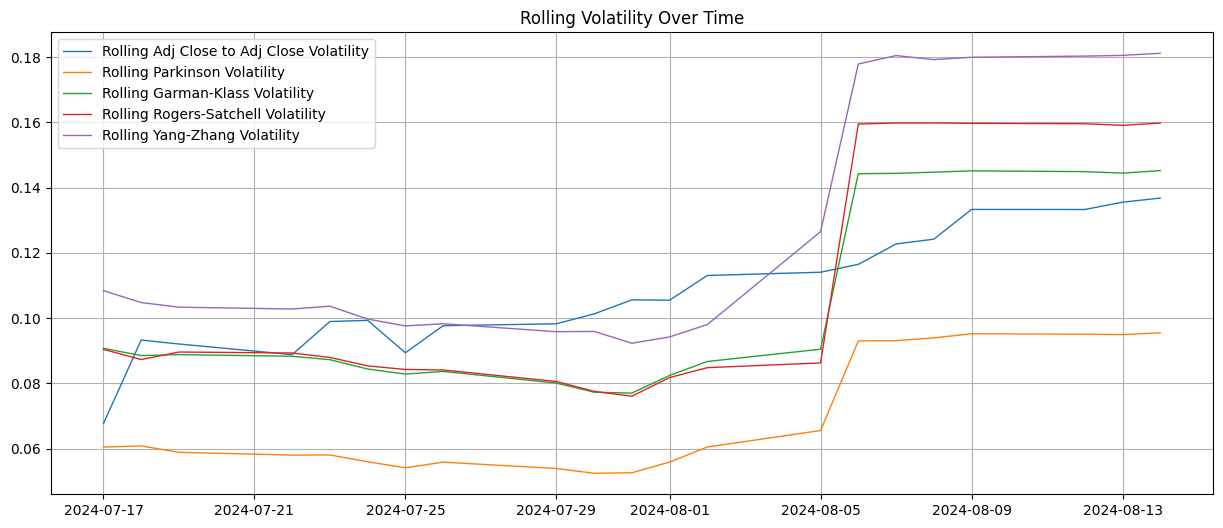

,cc,parkinson,garman_klass,rogers_satchell,yang_zhang
Date,,,,,
2024-08-14,13.676752,9.54712,14.518257,15.974009,18.114177


In [9]:
df1 = pd.concat([
    cc_volatility(df['Adj Close'], 20)*100,
    parkinson_volatility(df, 20)*100,
    garman_klass_volatility(df, 20)*100,
    rogers_satchell_volatility(df, 20)*100,
    yang_zhang_volatility(df, 20)*100,
    ],axis=1)
df1.columns = ['cc', 'parkinson', 'garman_klass', 'rogers_satchell', 'yang_zhang']



plt.figure(figsize=(15, 6))

# Plot rolling volatility
plt.plot(rolling_cc_volatility[-21:], label='Rolling Adj Close to Adj Close Volatility', linewidth=1)
plt.plot(rolling_parkinson_volatility[-21:], label='Rolling Parkinson Volatility', linewidth=1)
plt.plot(rolling_garman_klass_volatility[-21:], label='Rolling Garman-Klass Volatility', linewidth=1)
plt.plot(rolling_rogers_satchell_volatility[-21:], label='Rolling Rogers-Satchell Volatility', linewidth=1)
plt.plot(rolling_yang_zhang_volatility[-21:], label='Rolling Yang-Zhang Volatility', linewidth=1)

# Add titles and labels
plt.title('Rolling Volatility Over Time')

# Add x-axis labels
# plt.xticks(ticks=range(len(df.index[-21:])), labels=df.index.date[-21:], rotation=45)

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

df1[-1:]
